# Exercises

### Code for data generation

In [1]:
import numpy as np
np.random.seed(0)
import scipy
import scipy.stats
import scipy.io
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
sns.set_theme(context='notebook',style='white',font_scale=1.5,
              rc = {'axes.spines.top':False,'axes.spines.right':False})


%matplotlib inline 
plt.rcParams['figure.figsize'] = [10, 5]
from ipywidgets import interact
import ipywidgets as widgets

from scipy.stats import poisson

track_length = 200. # the length of our linear track (eg in centimeter)
average_firing_rate = 5 # the peak firing rate, averaged across the population 
n_cells = 100 # how many cells we are recording
pf_centers = np.random.rand(n_cells) * track_length # the centers of the place fields for all cells drawn randomly with a uniform distribution on the track
pf_size = np.random.gamma(10, size=n_cells) # the size (width) of the place fields, drawn randomly from a gamma distribution 
pf_rate = np.random.exponential(scale=average_firing_rate, size=n_cells) # the peak firing rate for each cell, drawn from an exponential distribution

In [2]:
bins = np.arange(0., 200.)
true_firing_rate_maps = np.zeros((n_cells, len(bins)))
for i in range(n_cells):
    true_firing_rate_maps[i,:] = pf_rate[i] * np.exp(-((bins-pf_centers[i])**2)/(2*pf_size[i]**2))

In [3]:
# GENERATE TRAJECTORY

n_runs = 10
use_stops = False
av_running_speed = 10 # the average running speed (in cm/s)
fps = 10 # the number of "video frames" per second 
running_speed_a = np.random.chisquare(10, size=n_runs) # running speed in the two directions
running_speed_b = np.random.chisquare(10, size=n_runs) 

stopping_time_a = np.random.chisquare(15, size=n_runs) # the time the mouse will spend at the two ends of the track
stopping_time_b = np.random.chisquare(15, size=n_runs)

x = np.array([])


for i in range(n_runs):
    stop1 = np.ones((int(stopping_time_a[i]*fps),)) * 0.
    run_length = len(bins) * fps / running_speed_a[i]
    run1 = np.linspace(0., float(len(bins)-1), int(run_length))
    stop2 = np.ones((int(stopping_time_b[i]*fps),)) * (len(bins)-1.)
    run_length = len(bins) * fps / running_speed_b[i]
    run2 = np.linspace(len(bins)-1., 0., int(run_length))
    if use_stops:
        x = np.concatenate((x, stop1, run1, stop2, run2))
    else:
         x = np.concatenate((x, run1, run2))
t = np.arange(len(x))/fps

In [4]:
sampling_rate = 10000.
t_sampling = np.arange(0, t[-1], 1. / sampling_rate)
x_sampling = np.floor(np.interp(t_sampling, t, x))
noise_firing_rate = 0.1 # the baseline noise firing rate
spikes = []

for i in range(n_cells):
    inst_rate = true_firing_rate_maps[i,x_sampling.astype(np.int32)] + noise_firing_rate
    spikes_loc = np.random.poisson(inst_rate/sampling_rate)
    sp = np.argwhere(spikes_loc)
    t_sp = t_sampling[sp]
    spikes.append(t_sp)

In [5]:
import pickle

file_name = 'linear_track_data.pickle' # change this name when you save new data

out_data = {}
out_data['x'] = x
out_data['t'] = t
out_data['spikes'] = spikes
out_data['track_length'] = track_length
out_data['fps'] = fps

with open('data/'+file_name,'wb') as f:
    pickle.dump(out_data,f)

## Exercise 1
---

You can find below the code that was used to generate the activity of place cells on a linear track.
Use the code and the decoding procedure you lerned about in the lesson to explore how different characteristic of the data impact our ability to decode position.
In particular:

A - Try to use different fraction of our data samples. How does the median error change when the the number of available sample gets larger? You do not need to re-generate any data, just randomly sub-sample the data to different fractions.

B - How many place cells do we need to reliably decode? Try to re-do the decoding using only 10 cell, then 20, and so on. How does the median error change? Does it reach an asymptote? (Also in this case, you do not need to re-generate the data, you can just select a random subset of cells each time)

C - Generate new data using the code below, changing the firing rate noise (changing the value of the variable `noise firing_rate`). How does this noise impact the decoding? 
# A

In [6]:
# Define the fractions of data samples to explore
fractions = [0.1, 0.2,0.3, 0.4, 0.5, 0.8]

# Perform decoding for each fraction
median_errors = np.zeros(len(fractions))


for i in range(len(fractions)):
    fraction = fractions[i]
    num_samples = int(len(x) * fraction)
    random_indices = np.sort(np.random.choice(range(len(x)), size=num_samples, replace=False))
    sub_x = x[random_indices]
    sub_t = t[random_indices]
    spike_positions = [np.interp(s, sub_t, sub_x) for s in spikes]
    space_bins = np.arange(0., track_length, 5.) # binnin in bins of 5 cms

    # we compute histograms for each cell
    spikes_hist= [np.histogram(s, space_bins)[0] for s in spike_positions]
    spikes_hist = np.asarray(spikes_hist)#np.vstack(spikes_hist).astype(np.float64)

    # we also need an "occupancy histogram" in order to normalize the firing rates maps 
    occupancy = np.histogram(sub_x, space_bins)[0] /  fps
    
    firing_rate_maps = spikes_hist / occupancy 

    spikes_count= [np.histogram(s,sub_t)[0] for s in spikes]
    spikes_count = np.asarray(spikes_count).T # we transpose the matrix to have the more familiar samples x features shape

    true_x = sub_x[:-1]
    decoding_times = sub_t[:-1]
    x_decoded = np.zeros_like(true_x)

    #calculate posterior and decode
    for t_bin in tqdm(range(len(decoding_times))):
        if sum(spikes_count[t_bin,:])>0: # Check if the time window contains spikes
            posterior = np.empty(firing_rate_maps.shape[-1])

            for j in range(len(posterior)):
                # Note that we work with log so that we can sum probabilities
                # instead of multiplying them 
                #posterior[i] = sum(np.log(poisson.pmf(spikes_count[t_bin,:],firing_rate_maps[:,i]/fps)+pow(1,-15)))
                posterior[j] = sum(poisson.logpmf(spikes_count[t_bin,:],firing_rate_maps[:,j]/fps)+pow(1,-15))


            x_decoded[t_bin] = space_bins[np.argmax(posterior)]
        else:
            x_decoded[t_bin] = np.nan   

    #compute error
    mse = np.sqrt((true_x-x_decoded)**2)
    median_error = np.nanmedian(np.sqrt((true_x-x_decoded)**2))
    median_errors[i] = median_error


100%|██████████████████████████████████████| 4623/4623 [00:14<00:00, 321.63it/s]


Text(0, 0.5, 'median error')

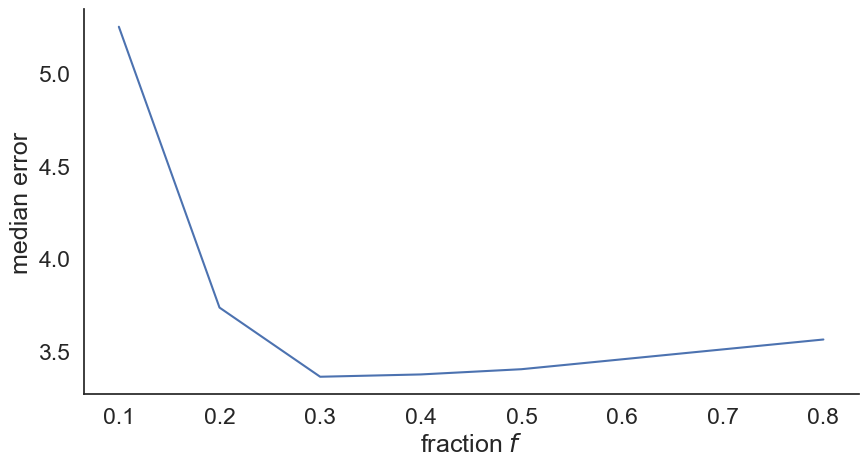

In [7]:
plt.plot(fractions,median_errors)
plt.xlabel('fraction $f$')
plt.ylabel('median error')

The median error decreases as a function of $f$. Furthermore, an $f$ of about .3 seems to be sufficient for good decoding.

# B

In [8]:
n_cells_list = [10,20,30,50,80,100] # how many cells we are recording

median_errors = np.zeros(len(n_cells_list))

for i in range(len(n_cells_list)):
    num_cells = n_cells_list[i]
    random_indices = np.sort(np.random.choice(len(spikes), size=num_cells, replace=False))
    sub_spikes = [spikes[i] for i in random_indices]
    spike_positions = [np.interp(s, t, x) for s in sub_spikes]
    space_bins = np.arange(0., track_length, 5.) # binnin in bins of 5 cms

    # we compute histograms for each cell
    spikes_hist= [np.histogram(s, space_bins)[0] for s in spike_positions]
    spikes_hist = np.asarray(spikes_hist)#np.vstack(spikes_hist).astype(np.float64)

    # we also need an "occupancy histogram" in order to normalize the firing rates maps 
    occupancy = np.histogram(x, space_bins)[0] /  fps
    
    firing_rate_maps = spikes_hist / occupancy 

    spikes_count= [np.histogram(s,t)[0] for s in sub_spikes]
    spikes_count = np.asarray(spikes_count).T # we transpose the matrix to have the more familiar samples x features shape

    true_x = x[:-1]
    decoding_times = t[:-1]
    x_decoded = np.zeros_like(true_x)

    #calculate posterior and decode
    for t_bin in tqdm(range(len(decoding_times))):
        if sum(spikes_count[t_bin,:])>0: # Check if the time window contains spikes
            posterior = np.empty(firing_rate_maps.shape[-1])

            for j in range(len(posterior)):
                # Note that we work with log so that we can sum probabilities
                # instead of multiplying them 
                #posterior[i] = sum(np.log(poisson.pmf(spikes_count[t_bin,:],firing_rate_maps[:,i]/fps)+pow(1,-15)))
                posterior[j] = sum(poisson.logpmf(spikes_count[t_bin,:],firing_rate_maps[:,j]/fps)+pow(1,-15))


            x_decoded[t_bin] = space_bins[np.argmax(posterior)]
        else:
            x_decoded[t_bin] = np.nan   

    #compute error
    mse = np.sqrt((true_x-x_decoded)**2)
    median_error = np.nanmedian(np.sqrt((true_x-x_decoded)**2))
    median_errors[i] = median_error


100%|██████████████████████████████████████| 5780/5780 [00:18<00:00, 319.81it/s]


Text(0, 0.5, 'median error')

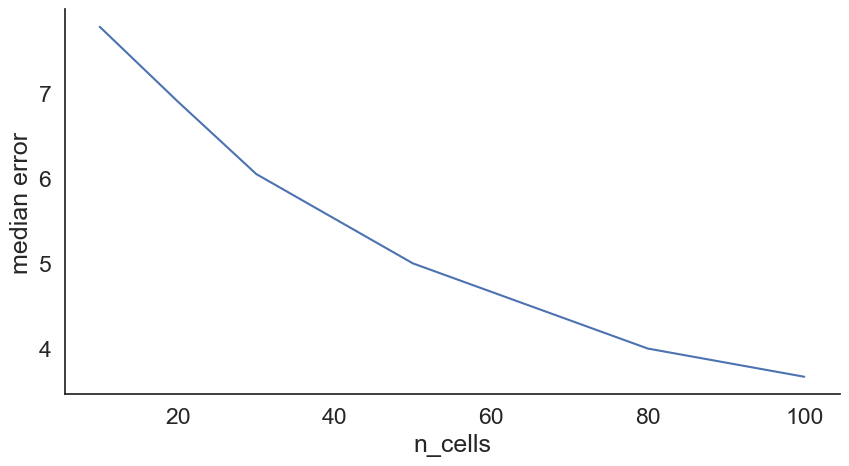

In [9]:
plt.plot(n_cells_list,median_errors)
plt.xlabel('n_cells')
plt.ylabel('median error')

Again, the median error decreases as a function of increasing number of place cells. It seems to reach an asymptote around `n_cells` = 100.

# C

In [10]:
noise_firing_rates = np.array([.1,.4,1,2,5]) # the baseline noise firing rate
    
median_errors = np.zeros(len(noise_firing_rates))

for i in range(len(noise_firing_rates)):
    noise_firing_rate = noise_firing_rates[i]
    spikes = []
    for idx in range(n_cells):
        inst_rate = true_firing_rate_maps[idx,x_sampling.astype(np.int32)] + noise_firing_rate
        spikes_loc = np.random.poisson(inst_rate/sampling_rate)
        sp = np.argwhere(spikes_loc)
        t_sp = t_sampling[sp]
        spikes.append(t_sp)
    
    spike_positions = [np.interp(s, t, x) for s in spikes]
    space_bins = np.arange(0., track_length, 5.) # binnin in bins of 5 cms

    # we compute histograms for each cell
    spikes_hist= [np.histogram(s, space_bins)[0] for s in spike_positions]
    spikes_hist = np.asarray(spikes_hist)#np.vstack(spikes_hist).astype(np.float64)

    # we also need an "occupancy histogram" in order to normalize the firing rates maps 
    occupancy = np.histogram(x, space_bins)[0] /  fps
    
    firing_rate_maps = spikes_hist / occupancy 

    spikes_count= [np.histogram(s,t)[0] for s in sub_spikes]
    spikes_count = np.asarray(spikes_count).T # we transpose the matrix to have the more familiar samples x features shape

    true_x = x[:-1]
    decoding_times = t[:-1]
    x_decoded = np.zeros_like(true_x)

    #calculate posterior and decode
    for t_bin in tqdm(range(len(decoding_times))):
        if sum(spikes_count[t_bin,:])>0: # Check if the time window contains spikes
            posterior = np.empty(firing_rate_maps.shape[-1])

            for j in range(len(posterior)):
                # Note that we work with log so that we can sum probabilities
                # instead of multiplying them 
                #posterior[i] = sum(np.log(poisson.pmf(spikes_count[t_bin,:],firing_rate_maps[:,i]/fps)+pow(1,-15)))
                posterior[j] = sum(poisson.logpmf(spikes_count[t_bin,:],firing_rate_maps[:,j]/fps)+pow(1,-15))


            x_decoded[t_bin] = space_bins[np.argmax(posterior)]
        else:
            x_decoded[t_bin] = np.nan   

    #compute error
    mse = np.sqrt((true_x-x_decoded)**2)
    median_error = np.nanmedian(np.sqrt((true_x-x_decoded)**2))
    median_errors[i] = median_error

100%|██████████████████████████████████████| 5780/5780 [00:17<00:00, 321.63it/s]


Text(0, 0.5, 'median error')

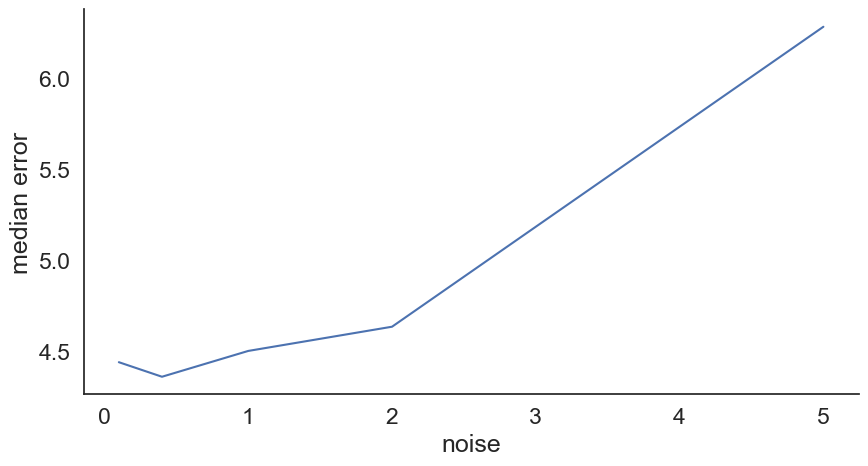

In [11]:
plt.plot(noise_firing_rates,median_errors)
plt.xlabel('noise')
plt.ylabel('median error')

The amount of baseline noise negatively impacts the quality of the decoding. This is of course expected, since more baseline firing rate noise decreases the SNR. 

## Exercise 2
---
In the loop implementation of the decoder, we used `poisson.logpmf(k,mu)` to calculate the log probability of observing $k$ spikes given an average firing rate of $\mu$. 
This is mathematically equivalent to `np.log(poisson.pmf(k,mu))`, in which we calculate the probability, and then take the log.


Re-run the decoding substituting this expression:

```
posterior[i] = sum(np.log(poisson.pmf(spikes_count[t_bin,:],firing_rate_maps[:,i]/fps)+pow(1,-15)))
```

To the line we are using to calculate the posterior.
Do you see any difference in the results? What do you think this is due to?

In [12]:
#first regenerate data using normal noise values
noise_firing_rate = 0.1 # the baseline noise firing rate
spikes = []

for i in range(n_cells):
    inst_rate = true_firing_rate_maps[i,x_sampling.astype(np.int32)] + noise_firing_rate
    spikes_loc = np.random.poisson(inst_rate/sampling_rate)
    sp = np.argwhere(spikes_loc)
    t_sp = t_sampling[sp]
    spikes.append(t_sp)

In [13]:
spike_positions = [np.interp(s, t, x) for s in spikes]
space_bins = np.arange(0., track_length, 5.) # binnin in bins of 5 cms

# we compute histograms for each cell
spikes_hist= [np.histogram(s, space_bins)[0] for s in spike_positions]
spikes_hist = np.asarray(spikes_hist)#np.vstack(spikes_hist).astype(np.float64)

# we also need an "occupancy histogram" in order to normalize the firing rates maps 
occupancy = np.histogram(x, space_bins)[0] /  fps
    
firing_rate_maps = spikes_hist / occupancy 

spikes_count= [np.histogram(s,t)[0] for s in sub_spikes]
spikes_count = np.asarray(spikes_count).T # we transpose the matrix to have the more familiar samples x features shape

true_x = x[:-1]
decoding_times = t[:-1]
x_decoded = np.zeros_like(true_x)

#calculate posterior and decode
for t_bin in tqdm(range(len(decoding_times))):
    if sum(spikes_count[t_bin,:])>0: # Check if the time window contains spikes
        posterior = np.empty(firing_rate_maps.shape[-1])

        for j in range(len(posterior)):
            # Note that we work with log so that we can sum probabilities
            # instead of multiplying them 
            posterior[j] = sum(np.log(poisson.pmf(spikes_count[t_bin,:],firing_rate_maps[:,j]/fps)+pow(1,-15)))
            #posterior[j] = sum(poisson.logpmf(spikes_count[t_bin,:],firing_rate_maps[:,j]/fps)+pow(1,-15))


        x_decoded[t_bin] = space_bins[np.argmax(posterior)]
    else:
        x_decoded[t_bin] = np.nan  

100%|██████████████████████████████████████| 5780/5780 [00:24<00:00, 237.41it/s]


Median error: 5.450605084663055 cm


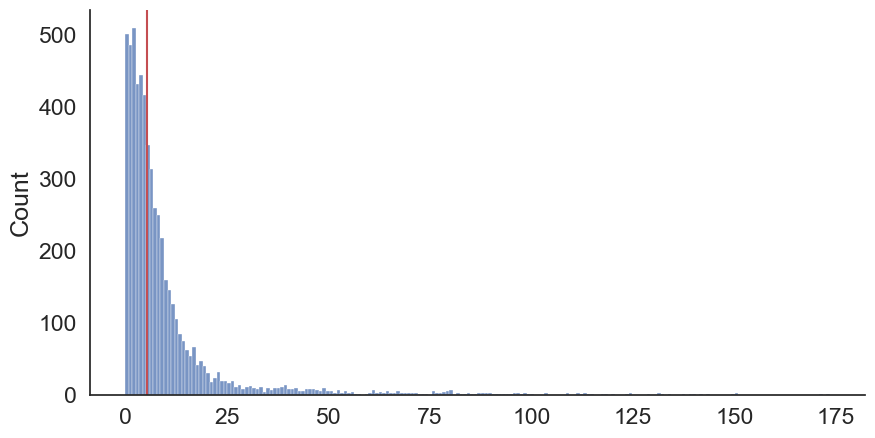

In [14]:
# error distribution
mse = np.sqrt((true_x-x_decoded)**2)
sns.histplot(mse)
plt.axvline(x = np.nanmedian(mse),c='r')
print(f'Median error: {np.nanmedian(mse)} cm')

Using `poisson.logpmf` I get a median error of about 4.5 cm. Using `np.log(poisson.pmf)` I get a median error of about 5.3, which is a higher median error. By using `poisson.logpmf`, the calculations involve additions and subtractions rather than multiplications and divisions. This helps to minimize issues related to numerical precision, especially when dealing with very small probabilities.

## Exercise 3
---
A - Estimate the quality of the sequence detection methods we saw in the lesson. How many false poistive does it find? How many false negatives?

B - Investigate the effect of `noise_x_react` and `noise_t_react` on the false positive rate and the false negative rate of our detection procedure.

C - What kind of sequence can our methods detect? What kind of activity, despide being sequential, could escape our detection method? Would you have an idea for a different method for sequence detection?


# A

First, the code for data generation:

In [15]:
# generate data 

n_events = 200 # number of reactivation events
event_duration = 100 # in bins
sampling_rate = 100 # sampling rate 
t_react = np.arange(0,100)
noise_x_react=5; # Noise in the reactivation of the sequence
noise_t_react=5; # Noise in the timing of the spikes 
noise_firing_rate = .1 # the baseline noise firing rate


reactivation_events = np.zeros((n_events,event_duration))
spikes_react = np.zeros((n_events,n_cells,event_duration))

for event in range(n_events):
    if(event<=n_events//2):
    #Generate "real" sequences for the first half of events
        x_start = np.random.uniform(0,track_length) # Starting point
        x_end = np.random.uniform(0,track_length) # Ending point
        x_react = np.linspace(x_start,x_end,event_duration) \
            +np.random.normal(0,noise_x_react,size=event_duration)

    else:
        #Pick locations randomly for the second half 
        x_react = np.random.uniform(0,track_length,size=event_duration);

    x_react[x_react<0]=0;
    x_react[x_react>track_length]=track_length
    
    #store reactivation sequence
    reactivation_events[event,:] = x_react

    
    # Generate spikes according to the location being reactivated in this event
    
    for i in range(n_cells):
        binned_x = np.digitize(x_react,bins=np.linspace(0,track_length,firing_rate_maps.shape[-1]))-1
        inst_rate = firing_rate_maps[i,binned_x] + np.random.normal(0,noise_firing_rate,size=len(binned_x))
        inst_rate[inst_rate<0] = 0
        spikes_loc = np.where(np.random.poisson(inst_rate/sampling_rate)>0)
        spikes_loc = spikes_loc + np.round(np.random.normal(0,noise_t_react,size=len(spikes_loc)))
        spikes_loc = spikes_loc[np.logical_and(spikes_loc>0,spikes_loc<event_duration)]
        spikes_react[event,i,spikes_loc.astype(int)] = 1
        
    


In [16]:
pfc_idxs = [np.argmax(rate_map) for rate_map in firing_rate_maps] 
sorted_idxs = np.argsort(pfc_idxs)

In [17]:
time_window = 10 # number of bins to aggregate during decoding

reactivation_slope = np.zeros(n_events)

for event in range(n_events):

    event_spikes = spikes_react[event]
    # First we bin the events in windows of 10 bins
    spikes_sampled = np.zeros((n_cells,event_spikes.shape[1]//time_window))
    # We generate a new spike matrix with the re-sized window
    for t_r in range(1,event_spikes.shape[1]//time_window):
        spikes_sampled[:,t_r] = np.sum(event_spikes[:,(t_r-1)*time_window :(t_r)*time_window],axis=1)

In [18]:
# to do: bayesian decoding
from scipy.stats import poisson
from scipy.stats import pearsonr

t_resize = 10 # We use spikes from multiple time windows for the decoding

reactivation_slopes = np.zeros(n_events)
reactivation_pvalues = np.zeros(n_events)

for event in range(n_events):

    event_spikes = spikes_react[event]
    spikes_sampled = np.zeros((n_cells,event_spikes.shape[1]//t_resize))

    # We generate a new spike matrix with the re-sized window
    for t_r in range(1,event_spikes.shape[1]//t_resize):
        spikes_sampled[:,t_r] = np.sum(event_spikes[:,(t_r-1)*t_resize :(t_r)*t_resize],axis=1)


    # We then perform decoding on the aggregated spikes
    x_decoded = np.zeros(spikes_sampled.shape[1])

    for t_bin in range(spikes_sampled.shape[1]):

        if sum(spikes_count[t_bin,:])>0: # Check if the time window contains spikes

            posterior = np.empty(firing_rate_maps.shape[-1])
            for i in range(len(posterior)):
                posterior[i] = sum(poisson.logpmf(spikes_sampled[:,t_bin],firing_rate_maps[:,i]*t_resize/fps)+pow(1,-15))

            x_decoded[t_bin] = space_bins[np.argmax(posterior)]

        else:
            x_decoded[t_bin] = np.nan   

        # We fit a line to the decoded positions, and save the slope
        idx = np.isfinite(x_decoded)
        slope,_ = np.polyfit(np.arange(len(x_decoded[idx])),x_decoded[idx],deg=1)
        reactivation_slopes[event] = slope
        # And calculate the pvalue of the pearson correlation
        corr = pearsonr(np.arange(len(x_decoded[idx])),x_decoded[idx])
        reactivation_pvalues[event] = corr[1]


N.B.: I added the idx line to remove the nan values, for some reason the polyfit could not handle nan inputs.

To count the number of false positive / false negatives, we know that the first 100 events are sequential, and the others are not. I define a threshold of 0.05 for the correlations to indicate significance of the slope method. First lets determine the sequence events:

In [19]:
sequential_event_indices = []
threshold = 0.05

for event in range(n_events):
    if reactivation_pvalues[event] < threshold:
        sequential_event_indices.append(event)
        
sequential_event_indices = np.array(sequential_event_indices)


Now count the number of false positives and false negatives:

In [20]:
ground_truth = np.arange(100) #first 100 events are sequential
false_positives = np.setdiff1d(sequential_event_indices, ground_truth) #returns set difference between arrays
false_negatives = np.setdiff1d(ground_truth, sequential_event_indices)
false_positive_count = len(false_positives)
false_negative_count = len(false_negatives)
false_positive_count,false_negative_count

(4, 81)

It seems that our sequence method is quite conservative in determining if there was a sequence, since there are not many false positives but there are many false negatives. We will check if this can be improved in the next question.

# B

The following chunck of code does the algorithm for different noise values:

In [25]:
vals = np.array([0,.1,.2,.4,.8,1.6,3.2,6.4,12.8,25.6])
false_positives_negatives = np.zeros([len(vals),2]) #first column is false positives


for j in tqdm(range(len(vals))):
    noise_x_react = vals[j]; #or set to a scalar and change the other
    noise_t_react = vals[j]; 
    reactivation_events = np.zeros((n_events,event_duration))
    spikes_react = np.zeros((n_events,n_cells,event_duration))
    for event in range(n_events):
        if(event<=n_events//2):
        #Generate "real" sequences for the first half of events
            x_start = np.random.uniform(0,track_length) # Starting point
            x_end = np.random.uniform(0,track_length) # Ending point
            x_react = np.linspace(x_start,x_end,event_duration) \
                +np.random.normal(0,noise_x_react,size=event_duration)

        else:
            #Pick locations randomly for the second half 
            x_react = np.random.uniform(0,track_length,size=event_duration);

        x_react[x_react<0]=0;
        x_react[x_react>track_length]=track_length
    
        #store reactivation sequence
        reactivation_events[event,:] = x_react

    
        # Generate spikes according to the location being reactivated in this event
    
        for i in range(n_cells):
            binned_x = np.digitize(x_react,bins=np.linspace(0,track_length,firing_rate_maps.shape[-1]))-1
            inst_rate = firing_rate_maps[i,binned_x] + np.random.normal(0,noise_firing_rate,size=len(binned_x))
            inst_rate[inst_rate<0] = 0
            spikes_loc = np.where(np.random.poisson(inst_rate/sampling_rate)>0)
            spikes_loc = spikes_loc + np.round(np.random.normal(0,noise_t_react,size=len(spikes_loc)))
            spikes_loc = spikes_loc[np.logical_and(spikes_loc>0,spikes_loc<event_duration)]
            spikes_react[event,i,spikes_loc.astype(int)] = 1    
            
    time_window = 10 # number of bins to aggregate during decoding

    reactivation_slope = np.zeros(n_events)

    for event in range(n_events):

        event_spikes = spikes_react[event]
        # First we bin the events in windows of 10 bins
        spikes_sampled = np.zeros((n_cells,event_spikes.shape[1]//time_window))
        # We generate a new spike matrix with the re-sized window
        for t_r in range(1,event_spikes.shape[1]//time_window):
            spikes_sampled[:,t_r] = np.sum(event_spikes[:,(t_r-1)*time_window :(t_r)*time_window],axis=1) 
     
    t_resize = 10 # We use spikes from multiple time windows for the decoding

    reactivation_slopes = np.zeros(n_events)
    reactivation_pvalues = np.zeros(n_events)

    for event in range(n_events):

        event_spikes = spikes_react[event]
        spikes_sampled = np.zeros((n_cells,event_spikes.shape[1]//t_resize))

        # We generate a new spike matrix with the re-sized window
        for t_r in range(1,event_spikes.shape[1]//t_resize):
            spikes_sampled[:,t_r] = np.sum(event_spikes[:,(t_r-1)*t_resize :(t_r)*t_resize],axis=1)


        # We then perform decoding on the aggregated spikes
        x_decoded = np.zeros(spikes_sampled.shape[1])

        for t_bin in range(spikes_sampled.shape[1]):

            if sum(spikes_count[t_bin,:])>0: # Check if the time window contains spikes

                posterior = np.empty(firing_rate_maps.shape[-1])
                for i in range(len(posterior)):
                    posterior[i] = sum(poisson.logpmf(spikes_sampled[:,t_bin],firing_rate_maps[:,i]*t_resize/fps)+pow(1,-15))

                x_decoded[t_bin] = space_bins[np.argmax(posterior)]

            else:
                x_decoded[t_bin] = np.nan   

            # We fit a line to the decoded positions, and save the slope
            idx = np.isfinite(x_decoded)
            slope,_ = np.polyfit(np.arange(len(x_decoded[idx])),x_decoded[idx],deg=1)
            reactivation_slopes[event] = slope
            # And calculate the pvalue of the pearson correlation
            corr = pearsonr(np.arange(len(x_decoded[idx])),x_decoded[idx])
            reactivation_pvalues[event] = corr[1]
            
    sequential_event_indices = []
    threshold = 0.05

    for event in range(n_events):
        if reactivation_pvalues[event] < threshold:
            sequential_event_indices.append(event)
        
    sequential_event_indices = np.array(sequential_event_indices)

    ground_truth = np.arange(100) #first 100 events are sequential
    false_positives = np.setdiff1d(sequential_event_indices, ground_truth) #returns set difference between arrays
    false_negatives = np.setdiff1d(ground_truth, sequential_event_indices)
    false_positive_count = len(false_positives)
    false_negative_count = len(false_negatives)
    false_positives_negatives[j,0]=false_positive_count
    false_positives_negatives[j,1]=false_negative_count
    
false_positives_negatives

100%|███████████████████████████████████████████| 10/10 [01:36<00:00,  9.69s/it]


array([[ 7., 77.],
       [ 4., 76.],
       [ 3., 77.],
       [ 2., 83.],
       [ 5., 84.],
       [ 2., 81.],
       [ 4., 79.],
       [ 4., 79.],
       [ 7., 89.],
       [ 9., 90.]])

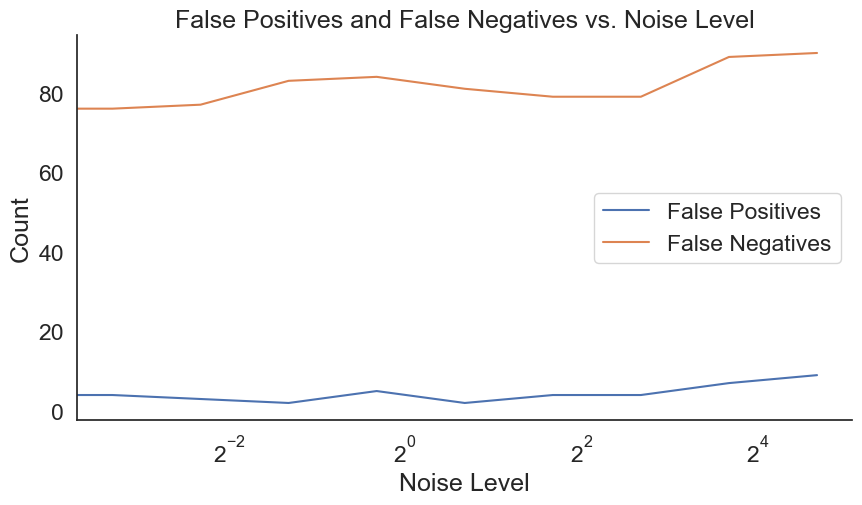

In [26]:
plt.plot(vals, false_positives_negatives[:,0], label='False Positives')
plt.plot(vals, false_positives_negatives[:,1], label='False Negatives')
plt.xscale('log', base=2)
plt.xlabel('Noise Level')
plt.ylabel('Count')
plt.title('False Positives and False Negatives vs. Noise Level')
plt.legend()
plt.show()

The amount of noise does not seem to affect our method by a large amount. For large noise values, the number of false negatives seems to increase a bit. But still, this is quite a good result. I also ran the block while only changing either noise_x_react or noise_t_react and the results are similar.

# C

Our method is able to capture sequence events, but being conservative about it. There are several ways for our method to miss a sequence event. One scenario where our method could miss the detection is when the sequential activity occurs at a very fast timescale, below the resolution of our sampling rate or time window size. If the time window is too large or the sampling rate is too low, rapid sequential events might not be captured accurately.

Additionally, our method assumes that the sequential activity patterns are linear in nature, and it fits a straight line to estimate the slope. If the sequential activity follows a non-linear trajectory or has complex dynamics, our method may not accurately capture the underlying sequence.